In [1]:
import numpy as np
import torch
import glob
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as tt
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [2]:
TRAIN_DIR = "E:\\Aquib\\MCA\\Python\\Fatima Fellowship\\datasets\\cell_images\\train\\"
VAl_DIR = "E:\\Aquib\\MCA\\Python\\Fatima Fellowship\\datasets\\cell_images\\test\\"
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Cell(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        list_files = glob.glob(self.root_dir + "*")
        # print(list_files)
        for class_path in list_files:
            class_name = class_path.split("\\")[-1]
            for img_path in glob.glob(class_path + "\\*.png"):
                self.data.append([img_path,class_name])
        self.class_map = {"parasitized":0, "uninfected":1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path,class_name = self.data[index]
        img = Image.open(img_path).convert('RGB')
        label = self.class_map[class_name]
        label = torch.tensor(label)
        if self.transform is not None:
            img = self.transform(img)
        return img,label

In [4]:
trans = tt.Compose([
    tt.Resize((64,64)),
    tt.ToTensor(),
    ])
train_dataset = Cell(TRAIN_DIR,transform = trans)
val_dataset = Cell(VAl_DIR,transform = trans)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [30]:
for data,labels in train_loader:
    print(labels)
    break

tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [5]:
def show_batch(dl):
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(images[:50],nrow=10).permute(1,2,0))
        break

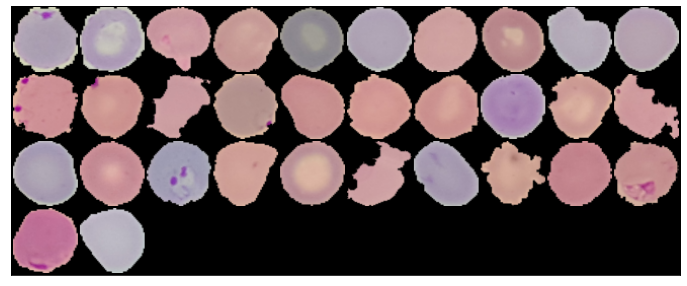

In [6]:
show_batch(dl=train_loader)

## Define a CNN Model

In [7]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(CNNBlock,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self,x):
        return self.conv(x)


class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1 = CNNBlock(3,64)
        self.conv2 = CNNBlock(64,128)
        self.conv3 = CNNBlock(128,512)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.linear1 = nn.Linear(512*8*8,1024)
        self.linear2 = nn.Linear(1024,512)
        self.linear3 = nn.Linear(512,2)


    def forward(self,x):
        x = self.conv1(x)
        x= self.pool(x)
        x = self.conv2(x)
        x= self.pool(x)
        x = self.conv3(x)
        x= self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x




In [8]:
model = Model().to(DEVICE)

In [9]:
model.parameters

<bound method Module.parameters of Model(
  (conv1): CNNBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): CNNBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv3): CNNBlock(
    (conv): Sequential(
      (0): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=32768, out_features=1024, bias=True)
  (linear2): Linear(in_features

In [10]:
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [11]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(DEVICE), target_.to(DEVICE)
        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_loader):
            data_t, target_t = data_t.to(DEVICE), target_t.to(DEVICE)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(val_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

Epoch 1

Epoch [1/5], Step [0/532], Loss: 0.7380
Epoch [1/5], Step [20/532], Loss: 0.8361
Epoch [1/5], Step [40/532], Loss: 0.3053
Epoch [1/5], Step [60/532], Loss: 0.6345
Epoch [1/5], Step [80/532], Loss: 0.6384
Epoch [1/5], Step [100/532], Loss: 0.1740
Epoch [1/5], Step [120/532], Loss: 0.3120
Epoch [1/5], Step [140/532], Loss: 0.3056
Epoch [1/5], Step [160/532], Loss: 0.1588
Epoch [1/5], Step [180/532], Loss: 0.0974
Epoch [1/5], Step [200/532], Loss: 0.1201
Epoch [1/5], Step [220/532], Loss: 0.0738
Epoch [1/5], Step [240/532], Loss: 0.0477
Epoch [1/5], Step [260/532], Loss: 0.3227
Epoch [1/5], Step [280/532], Loss: 0.3125
Epoch [1/5], Step [300/532], Loss: 0.1385
Epoch [1/5], Step [320/532], Loss: 0.2783
Epoch [1/5], Step [340/532], Loss: 0.1743
Epoch [1/5], Step [360/532], Loss: 0.0473
Epoch [1/5], Step [380/532], Loss: 0.1852
Epoch [1/5], Step [400/532], Loss: 0.0160
Epoch [1/5], Step [420/532], Loss: 0.1213
Epoch [1/5], Step [440/532], Loss: 0.0799
Epoch [1/5], Step [460/532], Lo

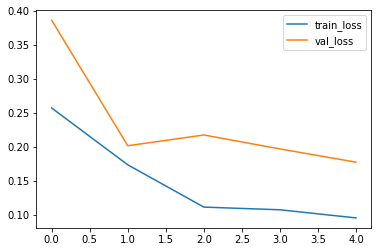

In [12]:
plt.plot(train_loss,label = "train_loss")
plt.plot(val_loss,label = "val_loss")
plt.legend()

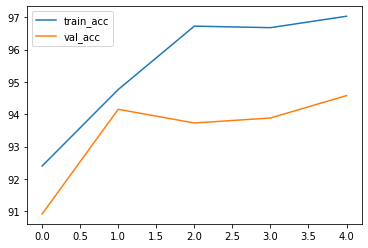

In [13]:
plt.plot(train_acc,label = "train_acc")
plt.plot(val_acc,label = "val_acc")
plt.legend()

In [14]:
from sklearn.metrics import f1_score
score = []
true = []
pred = []
with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_loader):
            data_t, target_t = data_t.to(DEVICE), target_t.to(DEVICE)
            outputs_t = model(data_t)
            _,pred_t = torch.max(outputs_t, dim=1)
            true.append(target_t.detach().cpu().numpy())
            pred.append(pred_t.detach().cpu().numpy())

In [15]:
pred_new = []
for x in pred:
    for i in x:
        pred_new.append(i)

In [16]:
true_new = []
for x in true:
    for i in x:
        true_new.append(i)

In [17]:
f1_score(true_new,pred_new)

0.9476808905380334

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_new,pred_new)
print(cm)

[[1182  118]
 [  23 1277]]


In [25]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1182  118]
 [  23 1277]]


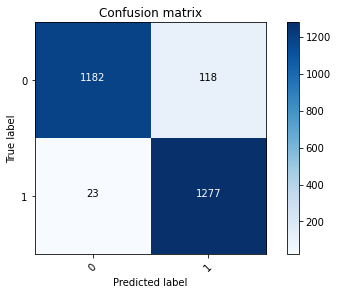

In [26]:
plot_confusion_matrix(cm,classes=[0,1])